In [1]:
import os
import pickle
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation, \
    Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


2023-07-06 21:16:24.098558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 21:16:24.125788: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 21:16:24.126453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 21:16:24.780578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
class SiameseNetwork(object):
    
    def __init__(self, seed, width, height, cells, loss, metrics, optimizer, dropout_rate):
        """
        Seed - The seed used to initialize the weights
        width, height, cells - used for defining the tensors used for the input images
        loss, metrics, optimizer, dropout_rate - settings used for compiling the siamese model (e.g., 'Accuracy' and 'ADAM)
        """
        K.clear_session()
        self.load_file = "weights.h5"
        self.seed = seed
        self.initialize_seed()
        self.optimizer = optimizer

        # Define the matrices for the input images
        input_shape = (width, height, cells)
        left_input = Input(input_shape)
        right_input = Input(input_shape)

        # Get the CNN architecture as presented in the paper (read the readme for more information)
        model = self._get_architecture(input_shape)
        encoded_l = model(left_input)
        encoded_r = model(right_input)

        # Add a layer to combine the two CNNs
        L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
        L1_siamese_dist = L1_layer([encoded_l, encoded_r])
        L1_siamese_dist = Dropout(dropout_rate)(L1_siamese_dist)

        # An output layer with Sigmoid activation function
        prediction = Dense(1, activation='sigmoid', bias_initializer=self.initialize_bias)(L1_siamese_dist)

        siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
        self.siamese_net = siamese_net
        self.siamese_net.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    def initialize_seed(self):
        """
        Initialize seed all for environment
        """
        os.environ['PYTHONHASHSEED'] = str(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

    def initialize_weights(self, shape, dtype=None):
        """
        Called when initializing the weights of the siamese model, uses the random_normal function of keras to return a
        tensor with a normal distribution of weights.
        """
        return K.random_normal(shape, mean=0.0, stddev=0.01, dtype=dtype, seed=self.seed)

    def initialize_bias(self, shape, dtype=None):
        """
        Called when initializing the biases of the siamese model, uses the random_normal function of keras to return a
        tensor with a normal distribution of weights.
        """
        return K.random_normal(shape, mean=0.5, stddev=0.01, dtype=dtype, seed=self.seed)

    def _get_architecture(self, input_shape):
        """
        Returns a Convolutional Neural Network based on the input shape given of the images. This is the CNN network
        that is used inside the siamese model. Uses parameters from the siamese one shot paper.
        """
        model = Sequential()
        model.add(
            Conv2D(filters=64,
                   kernel_size=(10, 10),
                   input_shape=input_shape,
                   kernel_initializer=self.initialize_weights,
                   kernel_regularizer=l2(2e-4),
                   name='Conv1'
                   ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D())

        model.add(
            Conv2D(filters=128,
                   kernel_size=(7, 7),
                   kernel_initializer=self.initialize_weights,
                   bias_initializer=self.initialize_bias,
                   kernel_regularizer=l2(2e-4),
                   name='Conv2'
                   ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D())

        model.add(
            Conv2D(filters=128,
                   kernel_size=(4, 4),
                   kernel_initializer=self.initialize_weights,
                   bias_initializer=self.initialize_bias,
                   kernel_regularizer=l2(2e-4),
                   name='Conv3'
                   ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D())

        model.add(
            Conv2D(filters=256,
                   kernel_size=(4, 4),
                   kernel_initializer=self.initialize_weights,
                   bias_initializer=self.initialize_bias,
                   kernel_regularizer=l2(2e-4),
                   name='Conv4'
                   ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))

        model.add(Flatten())
        model.add(
            Dense(4096,
                  activation='sigmoid',
                  kernel_initializer=self.initialize_weights,
                  kernel_regularizer=l2(2e-3),
                  bias_initializer=self.initialize_bias))
        return model

    def _load_weights(self, weights_file):
        """
        A function that attempts to load pre-existing weight files for the siamese model. If it succeeds then returns
        True and updates the weights, otherwise False.
        :return True if the file is already exists
        """
        # self.siamese_net.summary()
        self.load_file = weights_file
        if os.path.exists(weights_file):  # if the file is already exists, load and return true
            print('Loading pre-existed weights file')
            self.siamese_net.load_weights(weights_file)
            return True
        return False

    def fit(self, weights_file, train_path, validation_size, batch_size, epochs, early_stopping, patience, min_delta):
        """
        Function for fitting the model. If the weights already exist, just return the summary of the model. Otherwise,
        perform a whole train/validation/test split and train the model with the given parameters.
        """
        with open(train_path, 'rb') as f:
            x_train, y_train, names = pickle.load(f)
            
        x_train_0, x_val_0, y_train_0, y_val_0 = train_test_split(x_train[0], y_train,
                                                                  test_size=validation_size,
                                                                  random_state=self.seed)
        x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_train[1], y_train,
                                                                  test_size=validation_size,
                                                                  random_state=self.seed)
        x_train_0 = np.array(x_train_0, dtype='float64')
        x_val_0 = np.array(x_val_0, dtype='float64')
        x_train_1 = np.array(x_train_1, dtype='float64')
        x_val_1 = np.array(x_val_1, dtype='float64')
        x_train = [x_train_0, x_train_1]
        x_val = [x_val_0, x_val_1]
        if y_train_0 != y_train_1 and y_val_0 != y_val_1:
            raise Exception("y train lists or y validation list do not equal")
        y_train_both = np.array(y_train_0, dtype='float64')
        y_val_both = np.array(y_val_0, dtype='float64')
        if not self._load_weights(weights_file=weights_file):
            print('No such pre-existed weights file')
            print('Beginning to fit the model')
            callback = []
            if early_stopping:
                es = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, mode='auto', verbose=1)
                callback.append(es)
            self.siamese_net.fit(x_train, y_train_both, batch_size=batch_size, epochs=epochs,
                                 validation_data=(x_val, y_val_both), callbacks=callback, verbose=1)
            self.siamese_net.save("saved_model")
        # evaluate on the testing set
        loss, accuracy = self.siamese_net.evaluate(x_val, y_val_both, batch_size=batch_size)
        print(f'Loss on Validation set: {loss}')
        print(f'Accuracy on Validation set: {accuracy}')

    def evaluate(self, test_file, batch_size):
        """
        Function for evaluating the final model after training.
        test_file - file path to the test file.
        batch_size - the batch size used in training.

        Returns the loss and accuracy results.
        """
        with open(test_file, 'rb') as f:
            x_test, y_test, names = pickle.load(f)
        print(f'Available Metrics: {self.siamese_net.metrics_names}')
        y_test = np.array(y_test, dtype='float64')
        x_test[0] = np.array(x_test[0], dtype='float64')
        x_test[1] = np.array(x_test[1], dtype='float64')
        # evaluate on the test set
        loss, accuracy = self.siamese_net.evaluate(x_test, y_test, batch_size=batch_size)
        return loss, accuracy
        
print("Loaded Siamese Network")

Loaded Siamese Network


In [27]:

train_name = 'train'
test_name = 'test'
WIDTH = HEIGHT = 105
CEELS = 1
loss_type = "binary_crossentropy"
validation_size = 0.2
early_stopping = True

data_path = 'dataset'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


def run_combination(l, bs, ep, pat, md, seed, train_path, test_path):
    """
    This function gets the parameters and run the experiment.
    :return: loss - loss on the testing set, accuracy - accuracy on the testing set
    """
    # file types
    model_save_type = 'h5'
    # files paths
    initialize_seed(seed)
    parameters_name = f'seed_{seed}_lr_{l}_bs_{bs}_ep_{ep}_val_{validation_size}_' \
                      f'es_{early_stopping}_pa_{pat}_md_{md}'
    print(f'Running combination with {parameters_name}')
    # A path for the weights
    load_weights_path = os.path.join('weights', f'weights_{parameters_name}.{model_save_type}')

    siamese = SiameseNetwork(seed=seed, width=WIDTH, height=HEIGHT, cells=CEELS, loss=loss_type, metrics=['accuracy'],
                             optimizer=Adam(lr=l), dropout_rate=0.4)
    siamese.fit(weights_file=load_weights_path, train_path=train_path, validation_size=validation_size,
                batch_size=bs, epochs=ep, early_stopping=early_stopping, patience=pat,
                min_delta=md)
    loss, accuracy = siamese.evaluate(test_file=test_path, batch_size=bs)
    print(f'Loss on Testing set: {loss}')
    print(f'Accuracy on Testing set: {accuracy}')
    # predict_pairs(model)
    return loss, accuracy


def run():
    """
    The main function that runs the training and experiments. Uses the global variables above.
    """
    # file types
    data_set_save_type = 'pickle'
    train_path = os.path.join(data_path, f'{train_name}.{data_set_save_type}')  # A path for the train file
    test_path = os.path.join(data_path, f'{test_name}.{data_set_save_type}')  # A path for the test file
    result_path = os.path.join(data_path, f'results.csv')  # A path for the train file
    results = {'lr': [], 'batch_size': [], 'epochs': [], 'patience': [], 'min_delta': [], 'seed': [], 'loss': [],
               'accuracy': []}
    for l in lr:
        for bs in batch_size:
            for ep in epochs:
                for pat in patience:
                    for md in min_delta:
                        for seed in seeds:
                            loss, accuracy = run_combination(l=l, bs=bs, ep=ep, pat=pat, md=md, seed=seed,
                                                             train_path=train_path, test_path=test_path)
                            results['lr'].append(l)
                            results['batch_size'].append(bs)
                            results['epochs'].append(ep)
                            results['patience'].append(pat)
                            results['min_delta'].append(md)
                            results['seed'].append(seed)
                            results['loss'].append(loss)
                            results['accuracy'].append(accuracy)
    df_results = pd.DataFrame.from_dict(results)
    df_results.to_csv(result_path)


def initialize_seed(seed):
    """
    Initialize all relevant environments with the seed.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


if __name__ == '__main__':  if( cv2.waitKey(1) & 0XFF == ord('v')):
                print('v is pressed')
                anchor,frame =preprocess(frame)
                if( model.predict([anchor,frame])>=0.5):
                    print(True)
    
    seeds = [0]
    lr = [0.00005]
    batch_size = [32]
    epochs = [10]
    patience = [5]
    min_delta = [0.01]

    print(os.name)
    start_time = time.time()
    print('Starting the experiments')
    run()
    print(f'Total Running Time: {time.time() - start_time}')

posix
Starting the experiments
Running combination with seed_0_lr_5e-05_bs_32_ep_10_val_0.2_es_True_pa_5_md_0.01
No such pre-existed weights file
Beginning to fit the model
Epoch 1/10
55/55 [==============================] - 228s 4s/step - loss: 5.3273 - accuracy: 0.5869 - val_loss: 2.7880 - val_accuracy: 0.6386
Epoch 2/10
55/55 [==============================] - 224s 4s/step - loss: 1.8418 - accuracy: 0.6432 - val_loss: 1.3280 - val_accuracy: 0.6750
Epoch 3/10
55/55 [==============================] - 233s 4s/step - loss: 1.2396 - accuracy: 0.6574 - val_loss: 1.1899 - val_accuracy: 0.6386
Epoch 4/10
55/55 [==============================] - 233s 4s/step - loss: 1.1000 - accuracy: 0.6881 - val_loss: 1.1669 - val_accuracy: 0.6545
Epoch 5/10
55/55 [==============================] - 223s 4s/step - loss: 1.1838 - accuracy: 0.6767 - val_loss: 1.2787 - val_accuracy: 0.6318
Epoch 6/10
55/55 [==============================] - 214s 4s/step - loss: 1.1585 - accuracy: 0.6949 - val_loss: 1.1550 - va

2023-07-06 20:22:24.211758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4096]
	 [[{{node inputs}}]]
2023-07-06 20:22:24.871701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4096]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


14/14 [==============================] - 7s 473ms/step - loss: 1.2587 - accuracy: 0.6205
Loss on Validation set: 1.2586919069290161
Accuracy on Validation set: 0.6204545497894287
Available Metrics: ['loss', 'accuracy']
32/32 [==============================] - 16s 486ms/step - loss: 1.2694 - accuracy: 0.6020
Loss on Testing set: 1.2693830728530884
Accuracy on Testing set: 0.6019999980926514
Total Running Time: 2249.836026906967


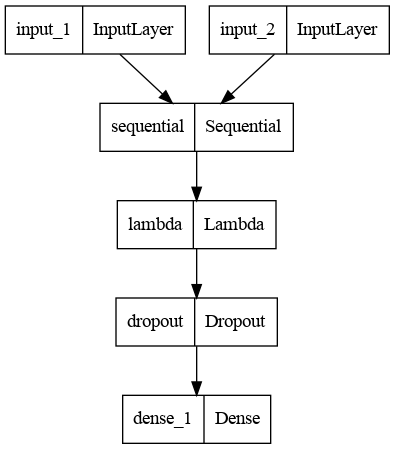

In [14]:
tf.keras.utils.plot_model(model,"model.png")

In [2]:
model = tf.keras.models.load_model('saved_model')

2023-07-06 21:16:35.459279: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2023-07-06 21:16:35.479886: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2023-07-06 21:16:35.479947: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


In [71]:
model.predict([img1,img2])

1/1 [==============================] - 0s 198ms/step


array([[0.30333441]], dtype=float32)

In [3]:
import cv2
import numpy as np

In [4]:
from PIL import Image,ImageOps

In [70]:
img2 = np.expand_dims(np.expand_dims(img2,0),3)

In [12]:
cam = cv2.VideoCapture(0)

while cam.isOpened():
    ret,frame = cam.read()
    if ret:
        cv2.imshow("frame",frame)
        try:
            if( cv2.waitKey(1) & 0XFF == ord('v')):
                print('v is pressed')
                anchor,frame =preprocess(frame)
                if( model.predict([anchor,frame],verbose=0)>=0.5):
                    print("Same person")
                else:
                    print("Differant person")
        except:
            pass
        if(cv2.waitKey(1) & 0XFF == ord('q')):
                break
            

cam.release()
cv2.destroyAllWindows()
        

v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Differant person
v is pressed
Differant person
v is pressed
Differant person
v is pressed
Differant person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person
v is pressed
Same person


In [10]:
def preprocess(frame,anchor = 'profile.jpeg'):
    anchor =np.expand_dims(np.expand_dims(np.asarray(ImageOps.grayscale(Image.open(anchor)).resize((105,105)),dtype='float32'),0),3)
    frame = np.expand_dims(np.expand_dims(np.asarray(ImageOps.grayscale(Image.fromarray(frame)).resize((105,105)),dtype='float32'),0),3)
    return anchor,frame
    

In [109]:
frame = np.expand_dims(np.expand_dims(np.asarray(ImageOps.grayscale(Image.fromarray(frame)).resize((105,105)),dtype='float32'),0),3)

In [112]:
model.predict([frame,anchor])

1/1 [==============================] - 0s 70ms/step


array([[0.42412263]], dtype=float32)

In [110]:
frame.shape

(1, 105, 105, 1)

In [111]:
anchor.shape

(1, 105, 105, 1)